# S&P 500 Stock Market Prediction Project

## Goal

- Predict whether the S&P 500 stock price will increase the following trading day
- Use historical price data and technical indicators to build a machine learning model
- Evaluate model performance using backtesting on out-of-sample data

## Imports

In [1]:
import prepare as p
import explore as e
import modeling as m

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score

## Acquire

- Acquired S&P 500 historical data from Yahoo Finance using the yfinance library
- Dataset contains daily stock data from 1927 to present
- Each row represents one trading day
- Original columns: Open, High, Low, Close, Volume, Dividends, Stock Splits

In [2]:
#Acquire S&P 500 data directly from Yahoo Finance
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
#Display raw data
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


## Prepare

**Data preparation steps:**
- Removed timezone information from dates and normalized to date-only format
- Only data after 1990 to have more recent movements be accounted for
- Kept only essential columns: Open, High, Low, Close, Volume
- Created target variable (1 if price goes up next day, 0 otherwise)
- Generated rolling average features for windows of 2, 5, 60, 250, and 1000 days
- Created trend features showing how many days the price went up in each rolling window
- Removed rows with missing values (primarily from initial rolling windows)
- After missing rows removed, the first complete date is in 1993
- Dataset after preparation: ~8,000+ trading days

In [3]:
#Prepare data for modeling
sp500 = p.prepare_sp500_for_modeling(sp500)
#Display the prepared data
sp500.head(10)

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250,Close_Ratio_1000,Trend_2,Trend_5,Trend_60,Trend_250,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.994331,0.992073,1.017602,1.063455,1.287386,929.630005,2326.860016,27767.719910,112579.109680,393627.719788
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.997365,0.990457,1.019627,1.046592,1.287323,928.760010,2323.160004,27775.729919,112606.739685,393731.089783
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.003248,0.998190,1.015651,1.051373,1.302724,924.899994,2318.709991,27784.619904,112627.299683,393834.169769
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.006561,1.005281,1.018875,1.059208,1.324191,925.179993,2317.869995,27791.759888,112649.939667,393941.839752
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.998864,1.000322,1.017962,1.061089,1.316742,929.720001,2320.320007,27800.399902,112676.009674,394056.019745
1993-12-21,465.839996,465.920013,464.029999,465.299988,273370000,467.320007,1,0.998819,1.004837,1.007579,1.058053,1.330874,932.230011,2320.470001,27808.619904,112702.829681,394168.079742
1993-12-22,465.079987,467.380005,465.079987,467.320007,272440000,467.380005,1,1.004341,1.011866,1.012545,1.064147,1.345541,931.149994,2322.709991,27812.119904,112728.359680,394283.759735
1993-12-23,467.299988,468.970001,467.299988,467.380005,227240000,470.540009,1,1.000128,1.008719,1.015801,1.067126,1.341004,932.619995,2328.190002,27817.909912,112756.529694,394403.769745
1993-12-27,467.399994,470.549988,467.350006,470.540009,171200000,470.940002,1,1.006761,1.008920,1.025298,1.072285,1.384226,934.700012,2332.230011,27825.179932,112785.929688,394522.619751


In [4]:
#Show basic stats of the dataset
e.show_basic_statistics(sp500)

Basic Statistics about the S&P500 Dataset
Total rows: 8,074
Date range: 1993-12-14 to 2026-01-12
Number of years: 32.1

Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow', 'Target', 'Close_Ratio_2', 'Close_Ratio_5', 'Close_Ratio_60', 'Close_Ratio_250', 'Close_Ratio_1000', 'Trend_2', 'Trend_5', 'Trend_60', 'Trend_250', 'Trend_1000']

Missing values:
Open                0
High                0
Low                 0
Close               0
Volume              0
Tomorrow            0
Target              0
Close_Ratio_2       0
Close_Ratio_5       0
Close_Ratio_60      0
Close_Ratio_250     0
Close_Ratio_1000    0
Trend_2             0
Trend_5             0
Trend_60            0
Trend_250           0
Trend_1000          0
dtype: int64


## Explore

**Exploration reveals:**
- The S&P 500 shows long-term upward growth with periodic corrections
- Target variable is relatively balanced: ~54% of days the market goes up
- Rolling averages help smooth out short-term volatility
- Volume patterns can indicate significant market events
- Daily returns follow approximately normal distribution with fat tails

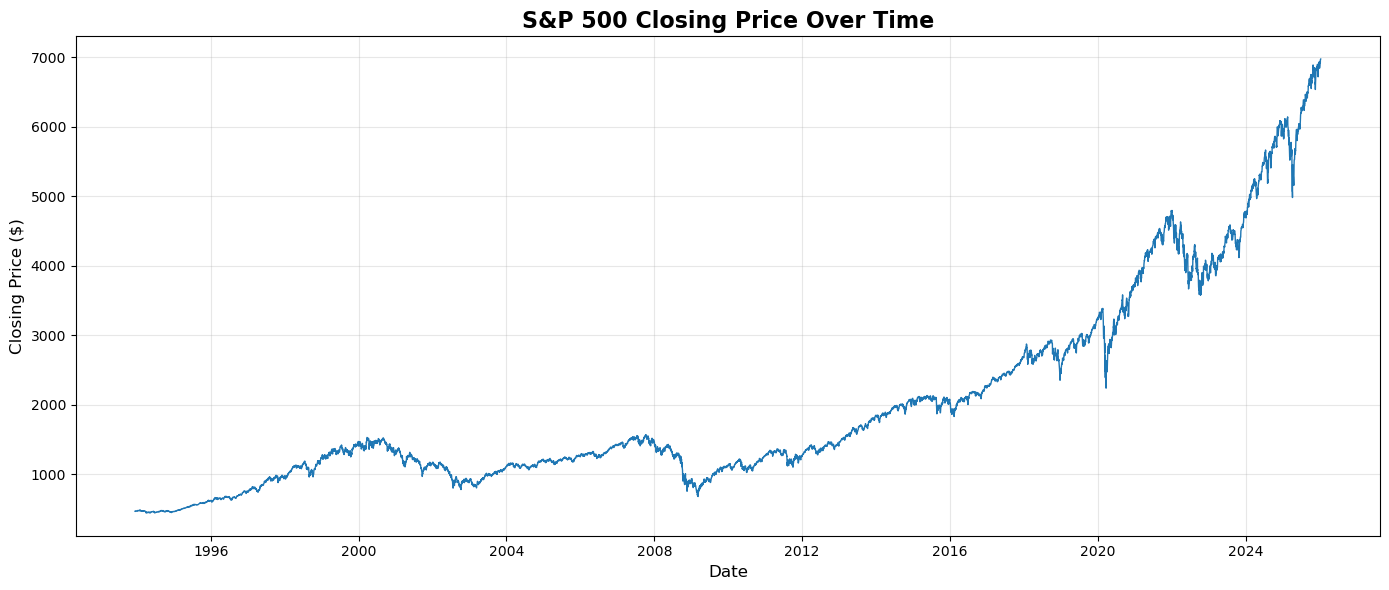

In [5]:
#Visualize closing price over time
e.plot_close_price_over_time(sp500)

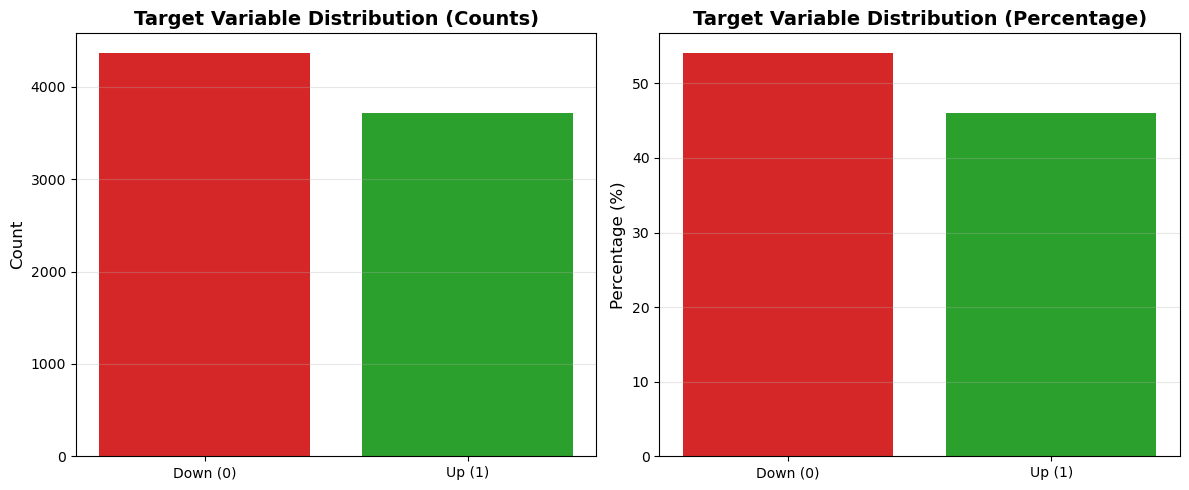

Days price went up: 4361 (54.01%)
Days price went down: 3713 (45.99%)


In [6]:
#Show target variable distribution
e.plot_target_distribution(sp500)

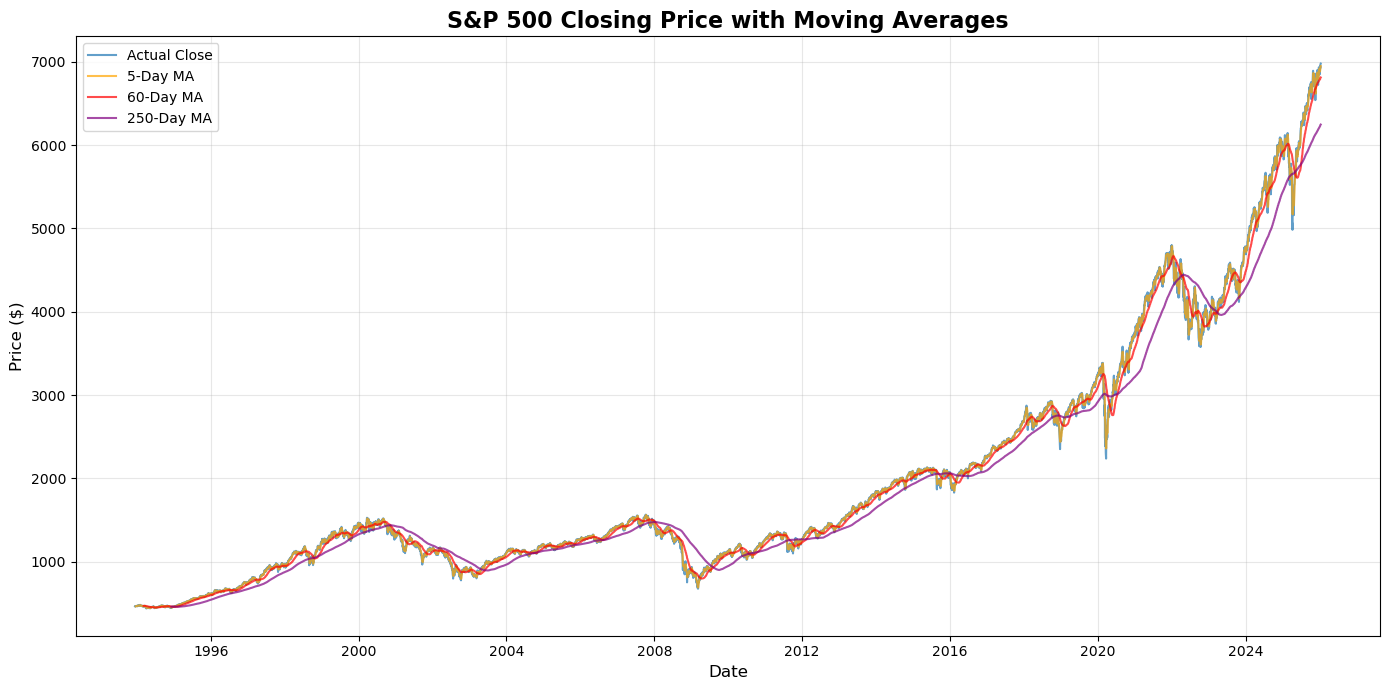

In [7]:
#Visualize moving averages
e.plot_rolling_averages(sp500, horizons=[5, 60, 250])

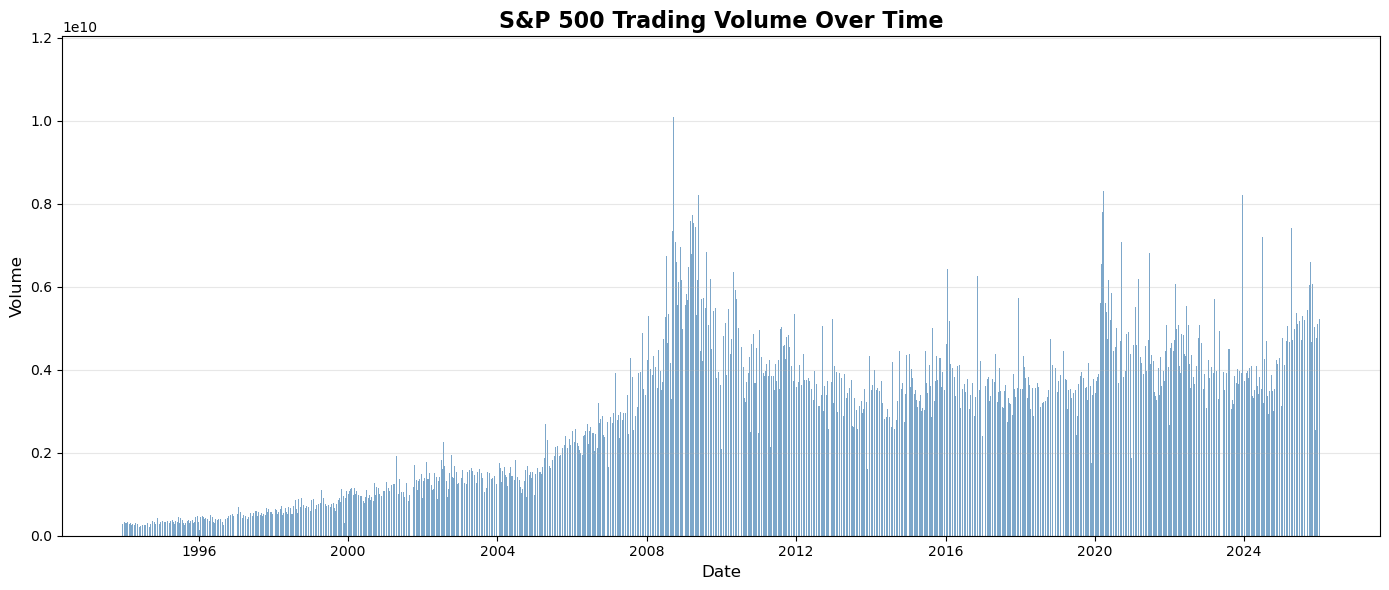

In [8]:
#Visualize trading volume
e.plot_volume_over_time(sp500)

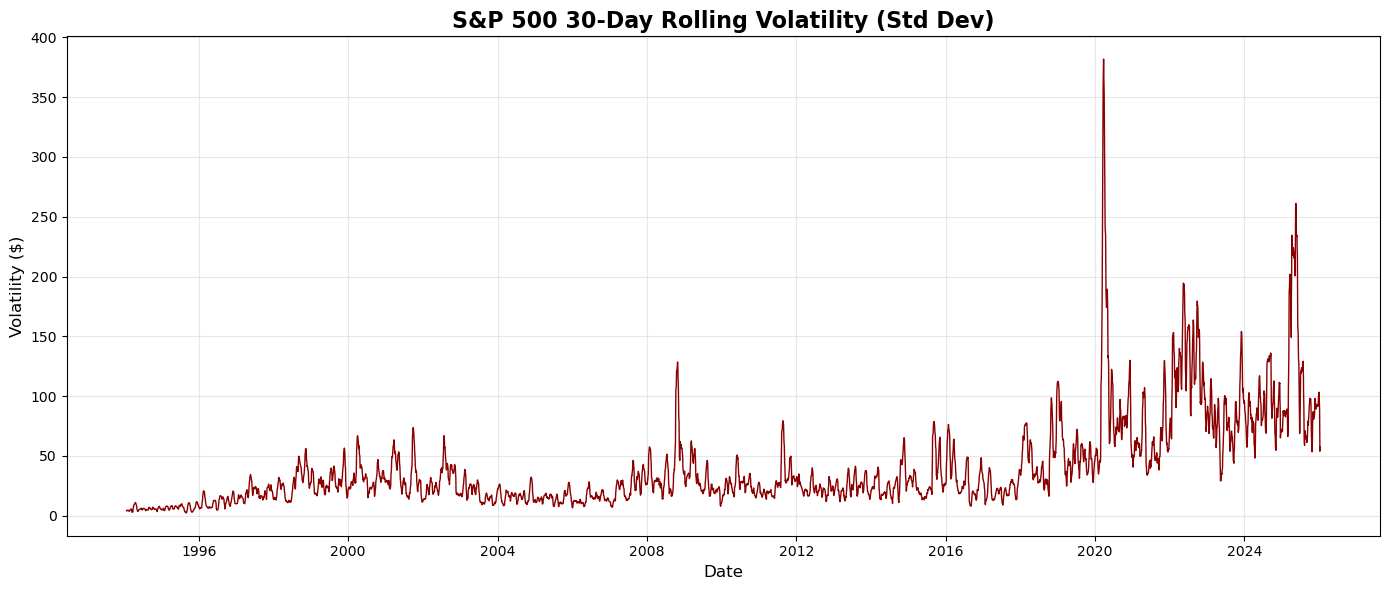

In [9]:
#Visualize price volatility
e.plot_price_volatility(sp500, window=30)

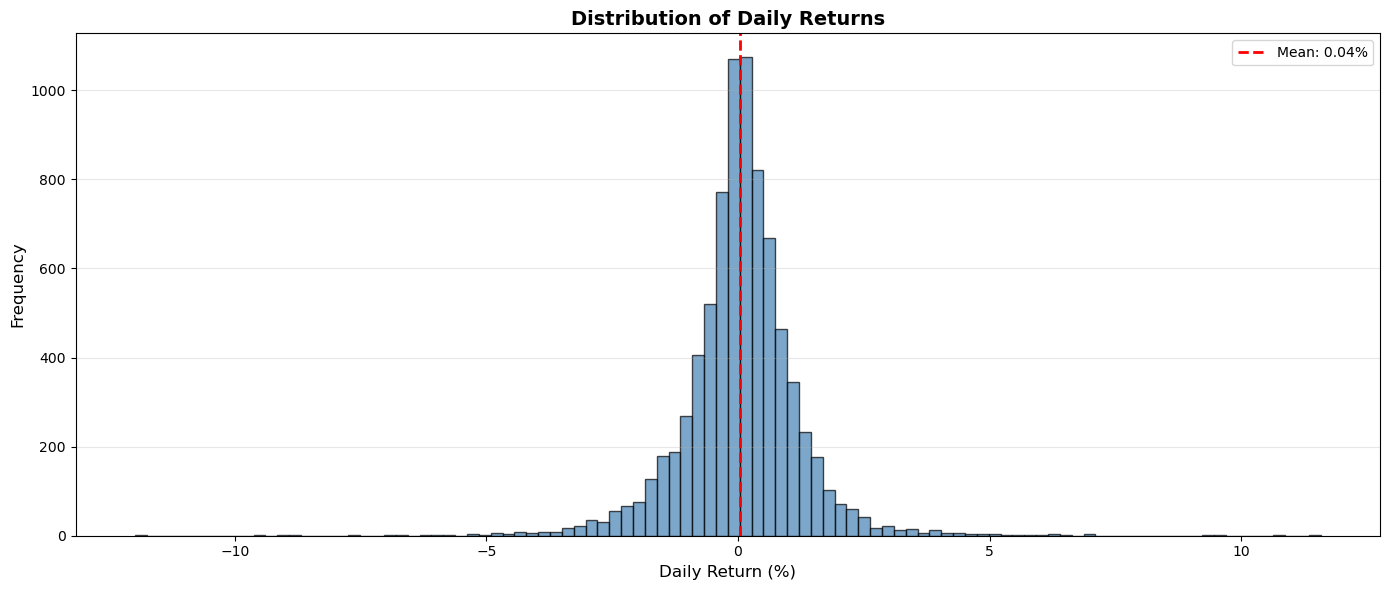

Mean daily return: 0.0405%
Std dev of returns: 1.1725%
Min return: -11.98%
Max return: 11.58%


In [10]:
#Analyze daily returns distribution
e.plot_returns_distribution(sp500)

**Key Findings from Exploration:**
- Rolling averages capture long-term market trends effectively
- Recent trend features (shorter windows) show higher correlation with target
- Market exhibits higher volatility during crisis periods (2008, 2020)
- The baseline accuracy (always predicting up) would be ~54%

## Modeling

**Modeling approach:**
- Using Random Forest Classifier for prediction
- Evaluation metric: Precision score (when we predict up, how often is it correct?)
- Features used: Rolling average ratios and trend features
- Backtesting strategy: Walk-forward validation starting at row 2500, testing 250 days at a time
- Baseline performance: 54% (always predicting market goes up)

In [11]:
#Define predictor features
predictors = ['Close_Ratio_2', 'Close_Ratio_5', 'Close_Ratio_60', 'Close_Ratio_250', 'Close_Ratio_1000',
    'Trend_2', 'Trend_5', 'Trend_60', 'Trend_250', 'Trend_1000']

print(f"Using {len(predictors)} features for prediction:")
for pred in predictors:
    print(f"  - {pred}")

Using 10 features for prediction:
  - Close_Ratio_2
  - Close_Ratio_5
  - Close_Ratio_60
  - Close_Ratio_250
  - Close_Ratio_1000
  - Trend_2
  - Trend_5
  - Trend_60
  - Trend_250
  - Trend_1000


### Model 1: Random Forest (Basic)

In [12]:
#Create and backtest first model
model = m.create_random_forest_model(n_estimators=100, min_samples_split=50, random_state=1)
predictions = m.backtest(sp500, model, predictors, start=2500, step=250)

In [13]:
#Evaluate model performance
m.print_model_results(predictions, model_name="Random Forest model 1")

Accuracy of Random Forest model 1 on training set: 0.50


### Model 2: Random Forest (Improved with More Trees)

In [14]:
#Create improved model with more trees
model2 = m.create_random_forest_model(n_estimators=200, min_samples_split=50, random_state=1)
predictions2 = m.backtest(sp500, model2, predictors, start=2500, step=250)

In [15]:
#Evaluate improved model
m.print_model_results(predictions2, model_name="Random Forest model 2")

Accuracy of Random Forest model 2 on training set: 0.50


### Model 3: Random Forest with Probability Threshold

This model uses `predict_proba` to get probability estimates and only predicts "up" when confidence is above 60%. This reduces the number of predictions but increases precision on those predictions.

In [16]:
#Create model with probability threshold
model3 = m.create_random_forest_model(n_estimators=200, min_samples_split=50, random_state=1)
predictions3 = m.backtest_with_threshold(sp500, model3, predictors, start=2500, step=250, threshold=0.6)

In [17]:
#Evaluate threshold model
m.print_model_results(predictions3, model_name="Random Forest model 3")

Accuracy of Random Forest model 3 on training set: 0.46


### Model Comparison

In [18]:
# Compare all models
comparison = m.compare_models({
    'RF (100 trees)': predictions,
    'RF (200 trees)': predictions2,
    'RF (200 trees, 60% threshold)': predictions3
})

print(comparison.to_string(index=False))

                        Model Accuracy Precision
               RF (100 trees)   0.4977    0.5556
               RF (200 trees)   0.5018    0.5576
RF (200 trees, 60% threshold)   0.4602    0.5379


### Feature Importance Analysis

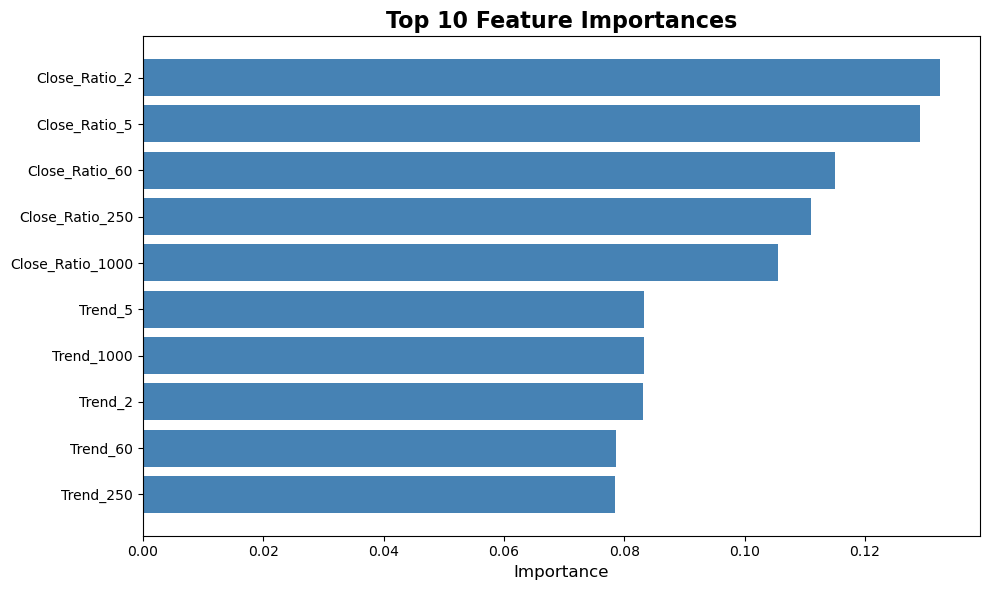

In [19]:
#Train final model on full dataset to get feature importances
final_model = m.create_random_forest_model(n_estimators=200, min_samples_split=50, random_state=1)
final_model.fit(sp500[predictors], sp500['Target'])

#Plot feature importance
m.plot_feature_importance(final_model, predictors, top_n=10)

**Modeling Findings:**
* Best performing model: Random Forest with 200 trees
* Precision of 55.76% means when we predict the market will go up, we're correct 55.76% of the time
* This is above the baseline of 54%, showing the model has learned useful patterns
* Using probability threshold reduces predictions and actually decreases both accuracy and precision
* Recent trend features (shorter time windows) are most important for predictions
* Longer-term rolling averages provide context but have less direct predictive power

## Conclusion

### Summary

- Built a machine learning model to predict S&P 500 daily price movements with 55.76% precision
- Used nearly 32 years of historical data (1993-present) with ~8,000 trading days
- Key features driving predictions:
    - Short-term price momentum (2-5 day rolling averages)
    - Medium-term trends (60 day patterns)
    - Long-term context (250-1000 day moving averages)
- Model performs slightly better than baseline (54%), demonstrating it has learned genuine market patterns
- Walk-forward backtesting ensures model evaluation on truly out-of-sample data

### Recommendations

- Incorporate additional features such as:
    - Market sentiment indicators (VIX volatility index)
    - Economic indicators (interest rates, GDP, unemployment)
    - Sector performance data
    - Trading volume patterns
- Test different prediction horizons (3-day, 5-day, weekly predictions)
- Implement ensemble methods combining multiple model types
- Consider using more sophisticated features like technical indicators (RSI, MACD, Bollinger Bands)

### Next Steps

- Collect and integrate additional market data sources
- Experiment with deep learning models (LSTM, GRU) that can capture temporal dependencies
- Develop a more sophisticated threshold strategy based on market conditions
- Implement risk management rules for practical trading applications
- Validate model on individual stocks beyond just the S&P 500 index